<a href="https://colab.research.google.com/github/AjarHDK/Brain_Tumor_Segmentation_U-Net/blob/main/2D_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 style="text-align: center; font-weight: bold;">
    <font color='blue'>2D Segmentation of Brain MRI using U-Net Architecture</font>
</h1>

## Overview

This notebook demonstrates the process of performing binary segmentation on brain MRI images using a U-Net architecture. The goal is to accurately segment regions of interest, such as abnormal tissues, from MRI scans. This task is crucial in medical imaging, assisting doctors in diagnosing conditions like brain tumors and lesions.

We will be using the [LGG MRI Segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) dataset from Kaggle, which consists of brain MRI images and corresponding binary masks. This dataset is derived from The Cancer Imaging Archive (TCIA) and contains MRI scans of patients with lower-grade gliomas (LGG). The MRI images include the **fluid-attenuated inversion recovery (FLAIR)** sequence, which is particularly a type of MRI sequence specifically designed to suppress the signal from fluids (like cerebrospinal fluid) to better highlight certain types of brain abnormalities, such as brain lesions and tumors.

Key details about the dataset:

*   **Image Modality:** FLAIR sequence MRI scans.
*   **Image Format:** TIFF.
*   **Image Size:** The MRI images are RGB images of shape 256x256x3 pixels.
*   **mask Size:** The masks are binary images of shape 256x256 pixels.
*   **Segmentation Task:** The binary masks indicate the presence or absence of tumor regions, making this a binary segmentation problem

We will walk through the following steps:

1.   Loading and preprocessing the MRI images and corresponding segmentation masks.
2.   Building a U-Net model, which is commonly used for medical image segmentation.
3.   Training the model on the dataset.
4.   Evaluating the performance using metrics such as Dice coefficient and Intersection over Union (IoU).
5.   Visualizing the segmentation results.



## Data Loading and Preprocessing

### 1. Import Libraries

In [ ]:
# Importing necessary libraries and modules for data processing, visualization, and model development
import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from skimage import io
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

%matplotlib inline

### 2. Load Data

In [ ]:
# Importing the necessary module to access Google Drive
from google.colab import drive

# Mounting Google Drive to access files stored there
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a directory to store Kaggle API credentials
!mkdir ~/.kaggle

In [ ]:
# Copy the Kaggle API key from Google Drive to the Kaggle directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# Set the permissions of the Kaggle API key file to be readable only by the owner
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the LGG MRI Segmentation dataset from Kaggle
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99% 709M/714M [00:12<00:00, 59.6MB/s]
100% 714M/714M [00:12<00:00, 62.2MB/s]


In [ ]:
# Unzip the LGG MRI Segmentation dataset into the specified directory
!unzip lgg-mri-segmentation.zip -d /content/drive/MyDrive/2D_seg

In [ ]:
# Change the working directory to the location where the dataset files are extracted
%cd /content/drive/MyDrive/2D_seg/lgg-mri-segmentation/kaggle_3m

/content/drive/.shortcut-targets-by-id/1KpjzPlHHe7RTnflFUVzVyLrpYAx0xpqt/2D_seg/lgg-mri-segmentation/kaggle_3m


In [ ]:
# Collect all image file paths from the specified directory and its subdirectories
images = glob.glob("/content/drive/MyDrive/2D_segmentation/lgg-mri-segmentation/kaggle_3m/*/*")


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

In [ ]:
brain_df.head(50)

In [ ]:
brain_df.image_path[1] # Path to the brain MRI image

In [ ]:
brain_df.mask_path[1] # Path to the brain MRI mask

MINI CHALLENGE :
  - Do we have a balanced dataset?
  - How many samples are classified as 'healthy'?

In [ ]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

The dataset is balanced with **2,556** **'healthy'** samples and **1,373** **'anomalous**' samples, providing a good balance for model training.

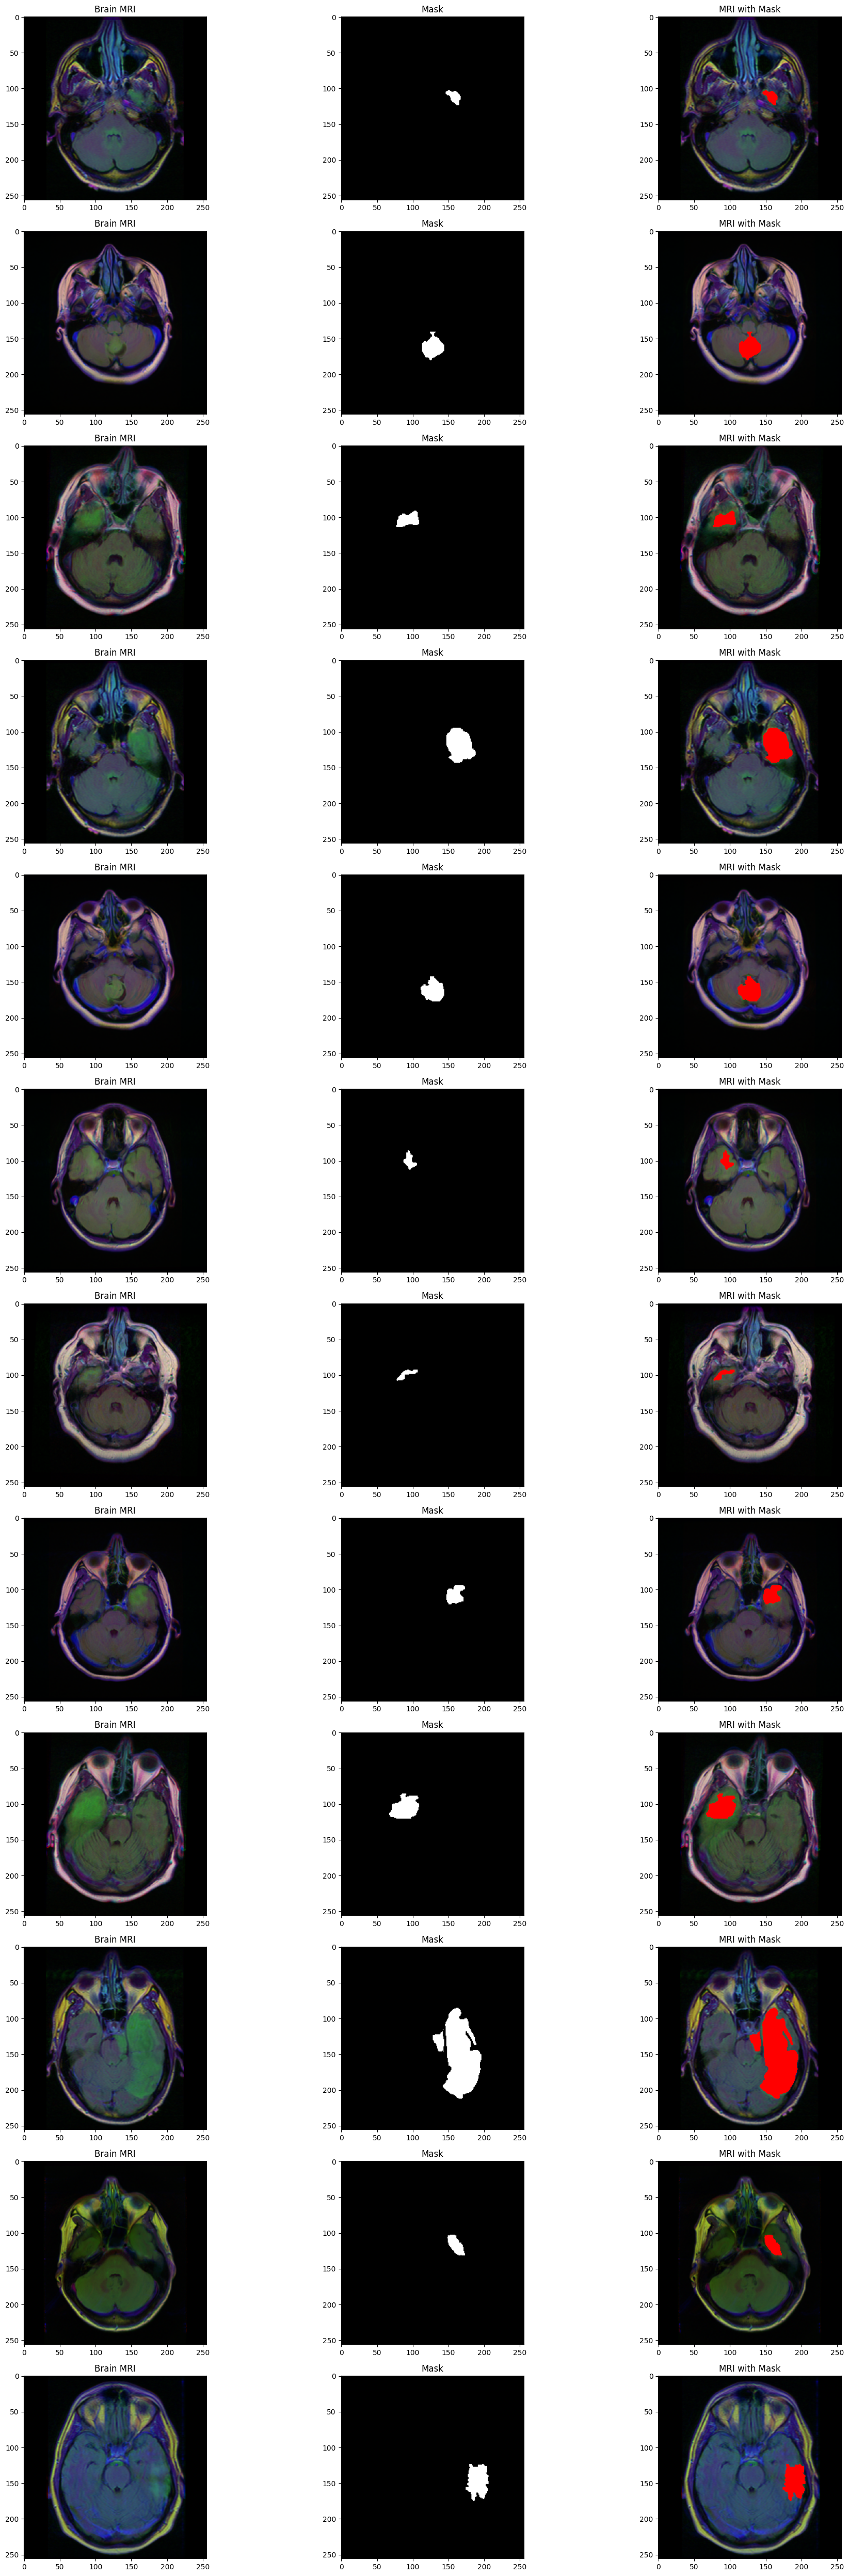

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

To manage the dataset size for training, we sampled **550** images with masks labeled as **'healthy'** and **450** images with masks labeled as **'anomalous'**, maintaining a balanced ratio. This subset ensures that the dataset remains balanced while being manageable for training.

In [ ]:
# Sample 500 images where mask == 0
df_mask_0 = brain_df[brain_df['mask'] == 0].sample(n=550, random_state=42)

# Sample 500 images where mask == 1
df_mask_1 = brain_df[brain_df['mask'] == 1].sample(n=450, random_state=42)

# Concatenate the two samples to create a balanced subset
df_balanced_subset = pd.concat([df_mask_0, df_mask_1])

# Shuffle the combined dataframe
brain_df = df_balanced_subset.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the distribution
print(brain_df['mask'].value_counts())

mask
0    550
1    450
Name: count, dtype: int64


### 3. Preprocess Images:

In [ ]:
# Assuming the dimensions and channels
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3


# Initialize the arrays
image_dataset = np.zeros((len(brain_df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
mask_dataset = np.zeros((len(brain_df), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.uint8)

print('Resizing training images and masks')
for i, row in tqdm(brain_df.iterrows(), total=len(brain_df)):
    # Load and resize the image
    img = imread(row['image_path'])[:,:,:IMG_CHANNELS]
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)
    image_dataset[i] = img

    # Load and resize the mask
    mask = imread(row['mask_path'], as_gray=True)
    img=np.array(img)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    mask_dataset[i] = mask

print('Done!')


Resizing training images and masks


100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]

Done!


In [ ]:
# Save the image dataset
np.save('image_dataset.npy', image_dataset)

# Save the mask dataset
np.save('mask_dataset.npy', mask_dataset)


In [ ]:
# Load the image dataset
image_dataset = np.load('image_dataset.npy')

# Load the mask dataset
mask_dataset = np.load('mask_dataset.npy')

# Optional: Check the shape of the loaded datasets
print('Image Dataset Shape:', image_dataset.shape)
print('Mask Dataset Shape:', mask_dataset.shape)


Image Dataset Shape: (1000, 256, 256, 3)
Mask Dataset Shape: (1000, 256, 256, 1)


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1000, 256, 256, 3)
Mask data shape is:  (1000, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.0  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.0  #PIxel values will be 0 or 1

In [ ]:
# Split the dataset into training and testing sets, with 20% allocated for testing
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

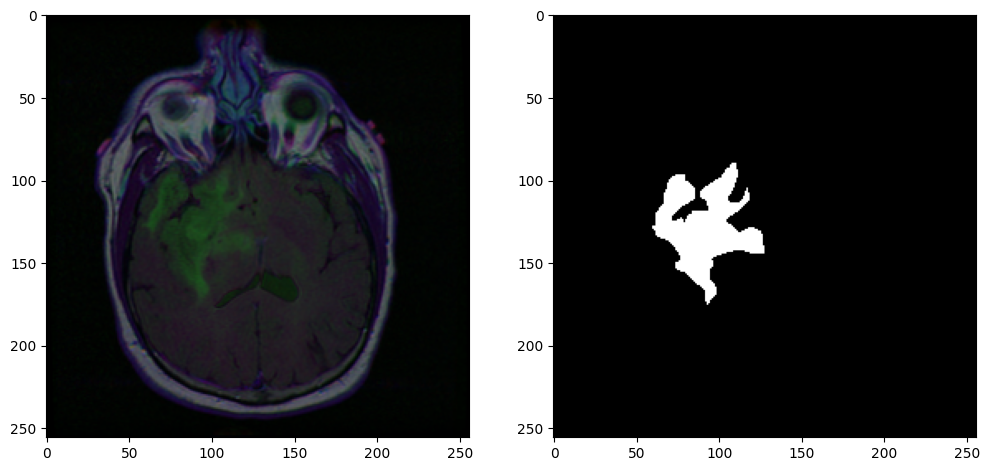

In [ ]:
#Sanity check, view few mages

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()




## Building a U-Net model

### 1. Model Architecture

The U-Net architecture includes:

- **Encoder:** Extracts features and reduces image size using convolutional layers and max pooling.
- **Bottleneck:** Processes features at the smallest spatial resolution.
- **Decoder:** Upsamples features and refines them with skip connections from the encoder to produce the final segmentation output.


![U-Net Architecture](https://miro.medium.com/max/1400/1*lvXoKMHoPJMKpKK7keZMEA.png)


### 2. Libraries Used for Building the Model

- **TensorFlow and Keras**: Utilized for constructing and training the U-Net model. Keras provides a high-level interface for defining the model architecture, while TensorFlow offers the backend engine for efficient computation.


In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# Define the dimensions and shape of the input images
IMG_HEIGHT = image_dataset.shape[1]  # Height of the images
IMG_WIDTH = image_dataset.shape[2]   # Width of the images
IMG_CHANNELS = image_dataset.shape[3]  # Number of channels in the images (e.g., 3 for RGB)

# Set the input shape for the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
# Build and compile the U-Net model
# `build_unet` function creates the U-Net model with the specified input shape and number of output classes
model = build_unet(input_shape, n_classes=1)

# Compile the model with the Adam optimizer, binary cross-entropy loss function, and accuracy metric
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture summary
model.summary()


sigmoid


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Training the model on the dataset.

In [ ]:
# Train the U-Net model
# Fit the model using the training data with a batch size of 16 and for 100 epochs
# Validation data is provided for monitoring performance on unseen data
# `shuffle=False` ensures the data order remains consistent across epochs
history = model.fit(X_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9046 - loss: 0.3273 - val_accuracy: 0.7188 - val_loss: 18.6232
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 892ms/step - accuracy: 0.9883 - loss: 0.0842 - val_accuracy: 0.9848 - val_loss: 0.1150
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 935ms/step - accuracy: 0.9886 - loss: 0.0560 - val_accuracy: 0.9848 - val_loss: 0.1185
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 934ms/step - accuracy: 0.9891 - loss: 0.0469 - val_accuracy: 0.9850 - val_loss: 0.2411
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 933ms/step - accuracy: 0.9897 - loss: 0.0404 - val_accuracy: 0.9851 - val_loss: 0.1597
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 936ms/step - accuracy: 0.9904 - loss: 0.0357 - val_accuracy: 0.9866 - val_loss: 0.2944
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 903ms/step - accuracy: 0.9908 - loss: 0.0329 - val_accuracy: 0.4133 - val_loss: 1.1957
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 938ms/step - accuracy: 0.9924 - loss: 0.0280 - v

In [ ]:
#Save the model for future use
model.save('1000images_binarySeg_100epochs.hdf5')

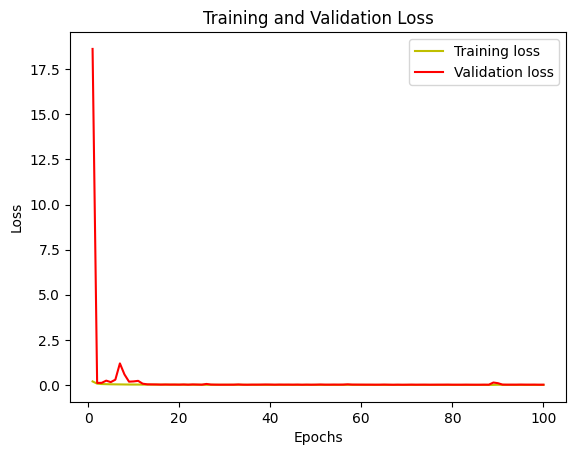

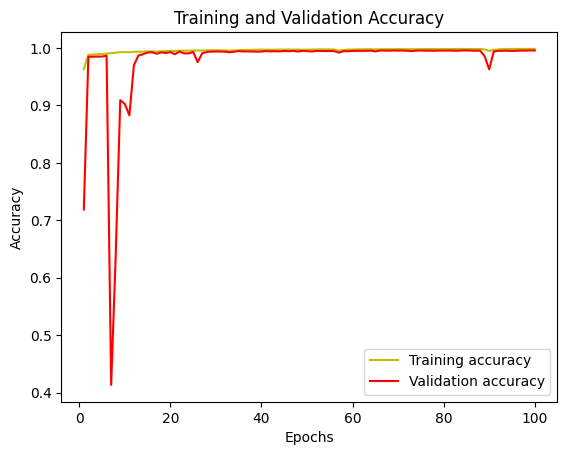

In [ ]:
# Plot training and validation loss and accuracy over epochs
# Extract loss and accuracy values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
#Load previously saved model
# The `compile=False` argument indicates that the model will not be compiled upon loading
model = load_model("/content/drive/MyDrive/2D_seg/lgg-mri-segmentation/kaggle_3m/1000images_binarySeg_100epochs.hdf5", compile=False)


Generate predictions for the test set using the trained model, which outputs probability maps for each image. Apply a threshold of 0.5 to these probabilities to obtain binary segmentation results, converting them into binary class predictions.












In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 658ms/step


## Evaluating the Model performance

We will evaluate the model's performance using two key metrics: **Intersection over Union (IoU)** and **Dice Coefficient**. Both metrics will provide insights into the accuracy and effectiveness of the segmentation.

## Intersection over Union (IoU)

Intersection over Union (IoU), also known as the Jaccard index, is a metric used to evaluate the performance of image segmentation models. It measures the overlap between the predicted segmentation mask and the ground truth mask.

### Definition

IoU quantifies the similarity between the predicted mask and the ground truth mask by calculating the ratio of the intersection to the union of these two masks. It ranges from 0 to 1, where:
- **0** indicates no overlap.
- **1** indicates a perfect match.

### Formula

The IoU is calculated using the following formula:

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|}
$$


where *A* and *B* are the sets of pixels in the ground truth and predicted masks, respectively.



In [ ]:
import numpy as np

def iou_score(y_true, y_pred, threshold=0.5):
    """
    Compute the Intersection over Union (IoU) score.
    Args:
    y_true: Ground truth binary mask.
    y_pred: Predicted binary mask.
    threshold: Threshold for binarizing predicted probabilities.

    Returns:
    IoU score.
    """
    # Binarize the predicted mask
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Flatten the arrays
    y_true_f = np.flatten(y_true)
    y_pred_f = np.flatten(y_pred_bin)

    # Compute the intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    if union == 0:
        return 1.0  # If both are empty
    return intersection / union

In [ ]:
# Calculate and print the Mean Intersection over Union (IoU) for model evaluation
# `MeanIoU` is initialized with the number of classes
# `update_state` computes the IoU using the predicted and true labels
# Print the result of the Mean IoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

### Dice Coefficient

The Dice coefficient (or Dice similarity coefficient, DSC) is a metric used to measure the similarity between two sets. In image segmentation tasks, it is used to evaluate the performance of a segmentation model by comparing the predicted segmentation mask to the ground truth mask.

### Definition

The Dice coefficient quantifies the overlap between the ground truth and predicted masks. It ranges from 0 to 1, where:
- **0** indicates no overlap.
- **1** indicates a perfect match.

### Formula

The Dice coefficient is calculated using the following formula:

$$
\text{Dice} = \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$

where *A* and *B* are the sets of pixels in the ground truth and predicted masks, respectively.


In [ ]:
def dice_coef(y_true, y_pred):
    """
    Compute the Dice coefficient.
    Args:
    y_true: Ground truth binary mask.
    y_pred: Predicted binary mask.

    Returns:
    Dice coefficient score.
    """
    # Flatten the arrays
    y_true_f = np.flatten(y_true)
    y_pred_f = np.flatten(y_pred)

    # Compute the intersection and sum
    intersection = np.sum(y_true_f * y_pred_f)
    sum_ = np.sum(y_true_f) + np.sum(y_pred_f)

    # Calculate Dice coefficient
    if sum_ == 0:
        return 1.0  # If both are empty
    return 2. * intersection / sum_

In [ ]:
dice_coef(y_pred_thresholded, y_test)

## Visualizing the segmentation results.

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(256, 256)


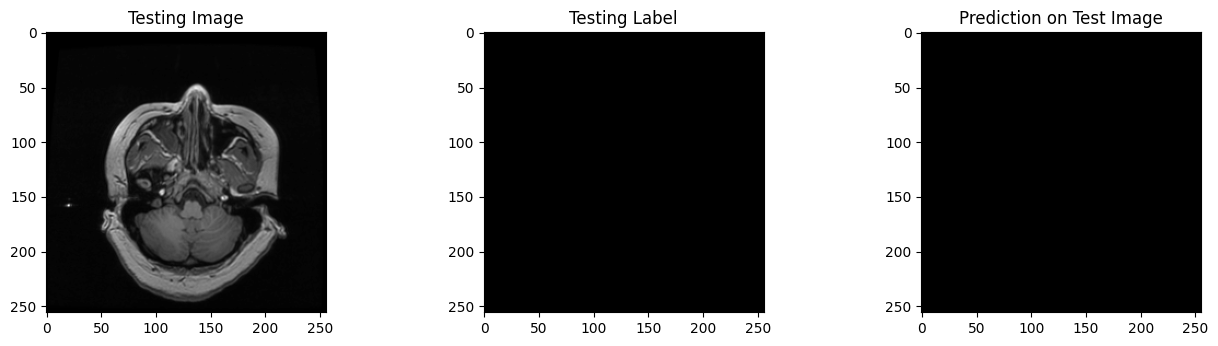

In [ ]:
# Select a random test image and its ground truth label
# Apply the model to predict the mask for this test image
# Expand the dimensions of the test image to fit the model input shape
# Predict the mask and apply a threshold to obtain binary predictions
# Display the test image, its ground truth label, and the model's prediction

threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)

# Generate prediction and apply threshold
prediction = (model.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
print(prediction.shape)

# Plot the test image, its ground truth label, and the model's prediction
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(prediction, cmap='gray')
plt.show()


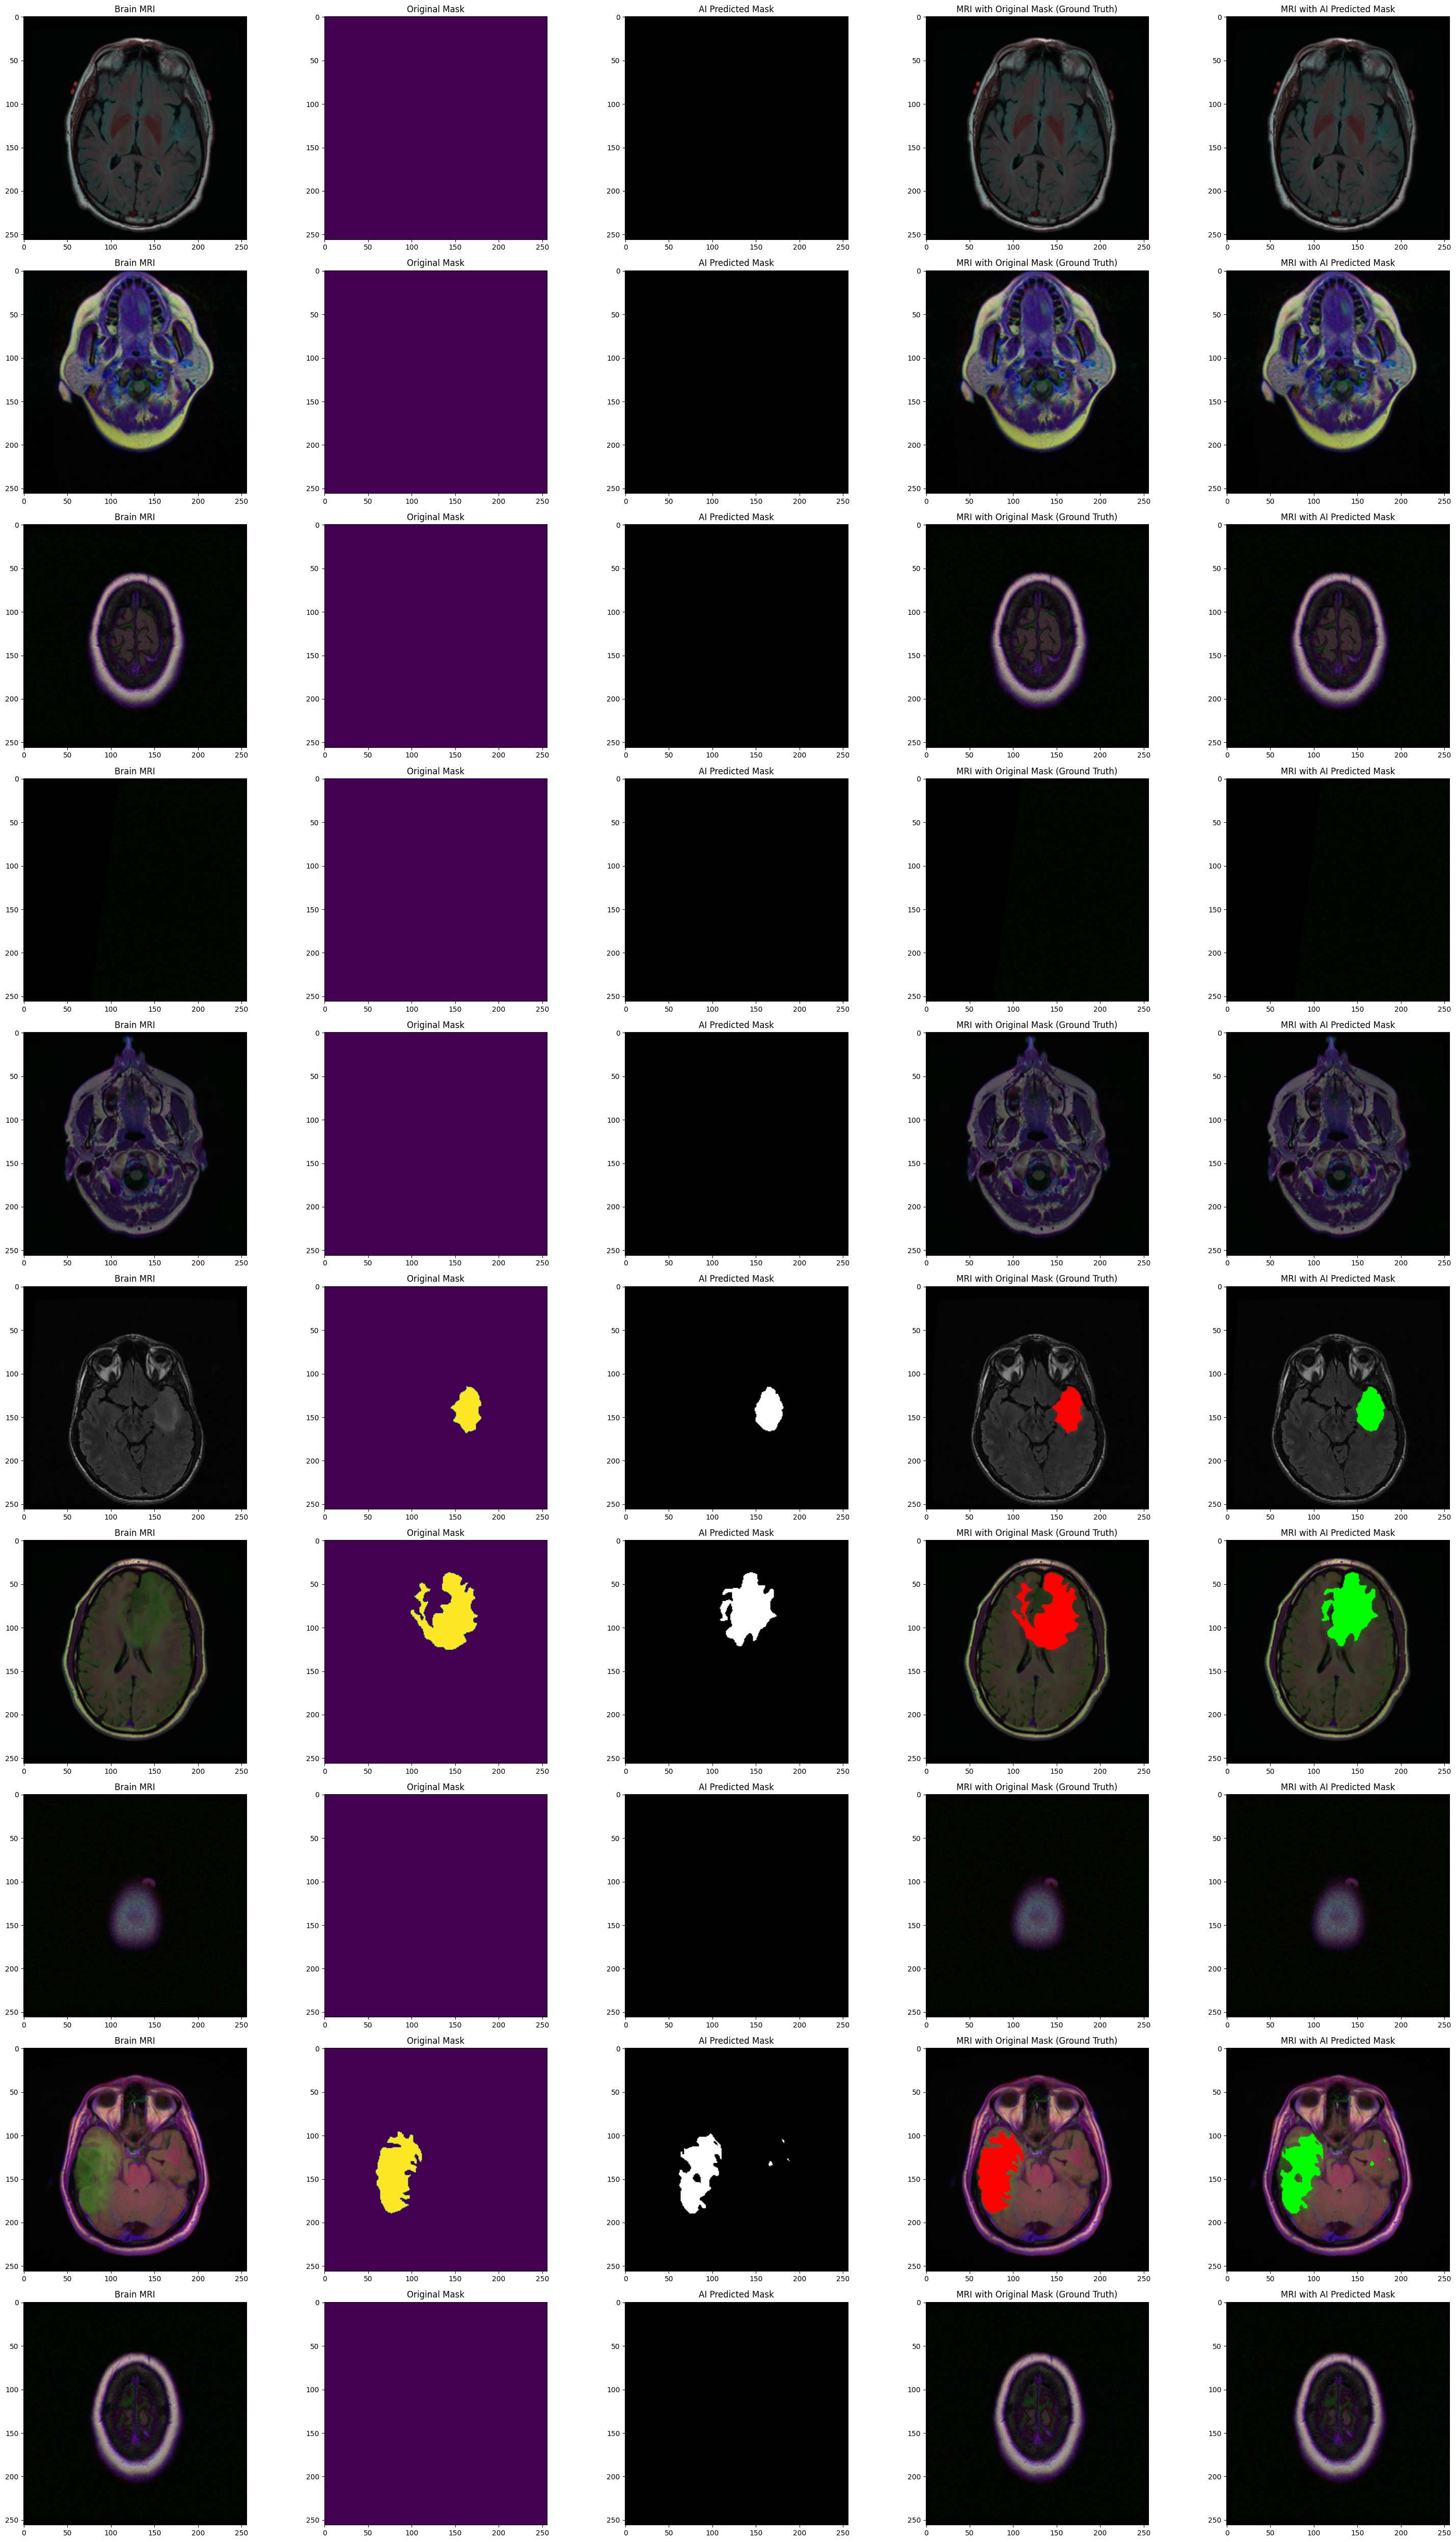

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to visualize
num_images = 10

# Randomly select indices to visualize
indices = np.random.choice(range(len(X_test)), num_images, replace=False)

fig, axs = plt.subplots(num_images, 5, figsize=(30, 50))

for count, idx in enumerate(indices):
    # Read the image
    img = X_test[idx]
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the original mask for the image
    ground_truth = y_test[idx]
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(ground_truth[:, :, 0], )

    # Obtain the predicted mask for the image
    predicted_mask = (y_pred[idx] > 0.5).astype(np.uint8)
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask[:, :, 0], cmap='gray')

    # Apply the original mask to the image
    img_with_original_mask = img.copy()
    img_with_original_mask[ground_truth[:, :, 0] == 1] = (255, 0, 0)  # Red for ground truth mask
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img_with_original_mask)

    # Apply the AI-predicted mask to the image
    img_with_predicted_mask = img.copy()
    img_with_predicted_mask[predicted_mask[:, :, 0] == 1] = (0, 255, 0)  # Green for predicted mask
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_with_predicted_mask)

fig.tight_layout()
plt.show()
